We will prepare the data which would be used for anomaly detection of IoT devices. The files are sourced from Numenta Anomaly detection benchmark (https://github.com/numenta/NAB/tree/master/data), CPU data is standard and does not have much variations.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras import regularizers
df = pd.read_csv("Data/device_temperature.csv")
df_cpu = pd.read_csv("Data/cpu_utilization.csv")
df.shape, df_cpu.shape

((22695, 2), (20400, 2))

Consider 20,000 rows as records length and split between train and test

In [47]:
df=df.head(20000)
df_cpu=df_cpu.head(20000)

Consolidate the data set with temperature and cpu values

In [48]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["cpu"] = df_cpu["value"]
df.rename(columns={"value": "temperature"}, inplace=True)
df.index = df["timestamp"]
df.drop("timestamp", axis=1, inplace=True)
df.shape

(20000, 2)

In [49]:
df

,temperature,cpu
timestamp,,
2013-12-02 21:15:00,73.967322,31.099
2013-12-02 21:20:00,74.935882,32.670
2013-12-02 21:25:00,76.124162,30.672
2013-12-02 21:30:00,78.140707,31.330
2013-12-02 21:35:00,79.329836,32.277
...,...,...
2014-02-10 06:30:00,99.411011,32.160
2014-02-10 06:35:00,99.386810,32.251
2014-02-10 06:40:00,99.376885,30.946


In [50]:
# Method for plotting the features
def plot_features(df):
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(df["temperature"], color="red", label="Temperature")
    ax.plot(df["cpu"], color="blue", label="CPU")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.legend(loc="upper left")
    plt.show()

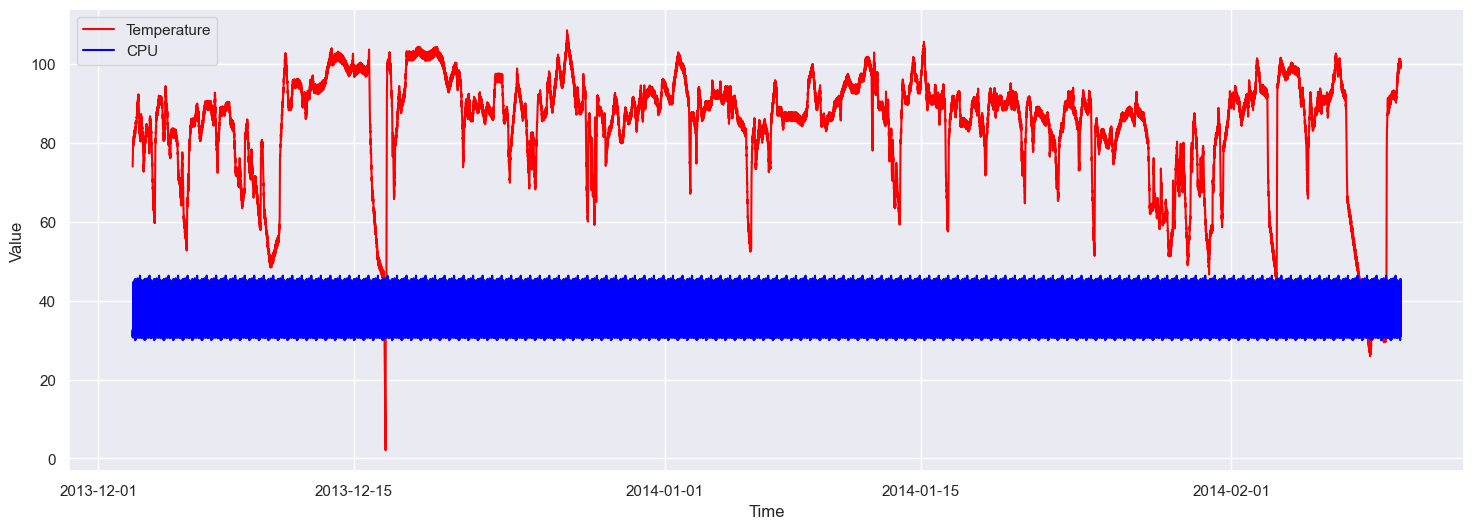

In [51]:
plot_features(df)

In [52]:
#Split Data between train and test
train = df[:3000]
test = df[3000:]
train.shape, test.shape

((3000, 2), (17000, 2))

In [53]:
# Use Sklearn preprocessing to normalize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (3000, 1, 2)
Test data shape: (17000, 1, 2)


After the data is prepared, we will train and create the model. We will be using the LSTM auto-encoder model for anomaly detection, this model can be obtained from the keras library.

In [54]:
# Define the model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,  kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1) 
    L3 = RepeatVector(X.shape[1])(L2) 
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3) 
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4) 
    output = TimeDistributed(Dense(X.shape[2]))(L5)     
    model = Model(inputs=inputs, outputs=output)
    return model

In [55]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 2)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 16)             1216      
                                                                 
 lstm_5 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector_1 (RepeatVec  (None, 1, 4)              0         
 tor)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_7 (LSTM)               (None, 1, 16)             1344      
                                                           

We will fit the model to our training data and train it for 100 epochs. We then plot the training losses to evaluate our model’s performance.

In [56]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

Epoch 1/100
285/285 [==============================] - 8s 8ms/step - loss: 0.2341 - val_loss: 0.1045
Epoch 2/100
285/285 [==============================] - 2s 7ms/step - loss: 0.0905 - val_loss: 0.0699
Epoch 3/100
285/285 [==============================] - 1s 5ms/step - loss: 0.0803 - val_loss: 0.0782
Epoch 4/100
285/285 [==============================] - 2s 7ms/step - loss: 0.0778 - val_loss: 0.0709
Epoch 5/100
285/285 [==============================] - 2s 6ms/step - loss: 0.0750 - val_loss: 0.0780
Epoch 6/100
285/285 [==============================] - 2s 6ms/step - loss: 0.0715 - val_loss: 0.0693
Epoch 7/100
285/285 [==============================] - 2s 6ms/step - loss: 0.0694 - val_loss: 0.0681
Epoch 8/100
285/285 [==============================] - 1s 5ms/step - loss: 0.0679 - val_loss: 0.0636
Epoch 9/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0671 - val_loss: 0.0649
Epoch 10/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0665 - val_lo

Plot the loss distribution of the training set

94/94 [==============================] - 1s 2ms/step


C:\Users\shdeb\AppData\Local\Temp\ipykernel_21792\17426507.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


(0.0, 0.5)

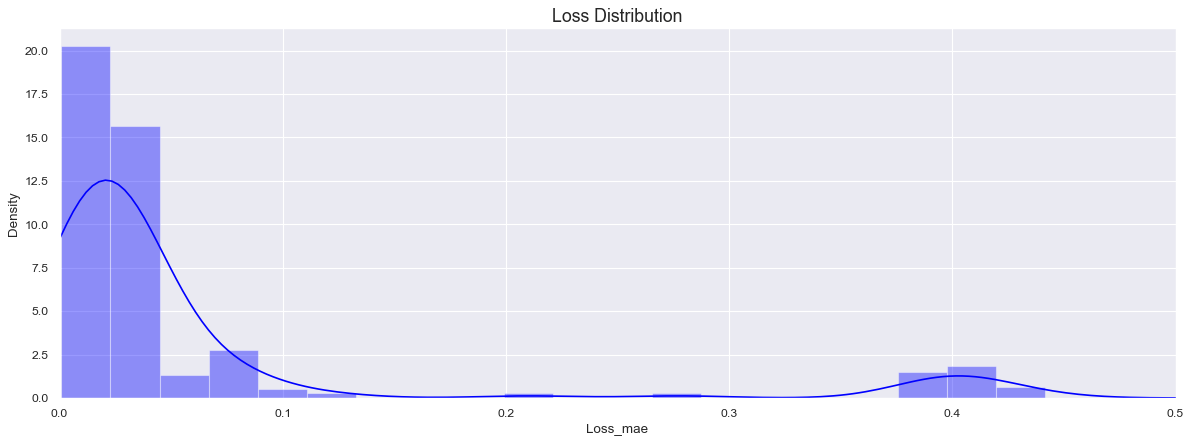

In [57]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index 
scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(18,6), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

Calculate the losses on the test set

In [61]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index 
scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.55
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

532/532 [==============================] - 2s 3ms/step


,Loss_mae,Threshold,Anomaly
timestamp,,,
2013-12-13 07:15:00,0.028014,0.55,False
2013-12-13 07:20:00,0.021686,0.55,False
2013-12-13 07:25:00,0.040501,0.55,False
2013-12-13 07:30:00,0.021022,0.55,False
2013-12-13 07:35:00,0.009843,0.55,False


Red line indicates our threshold value of loss, above which we mark as an anomalous benhaviour.

<Axes: xlabel='timestamp'>

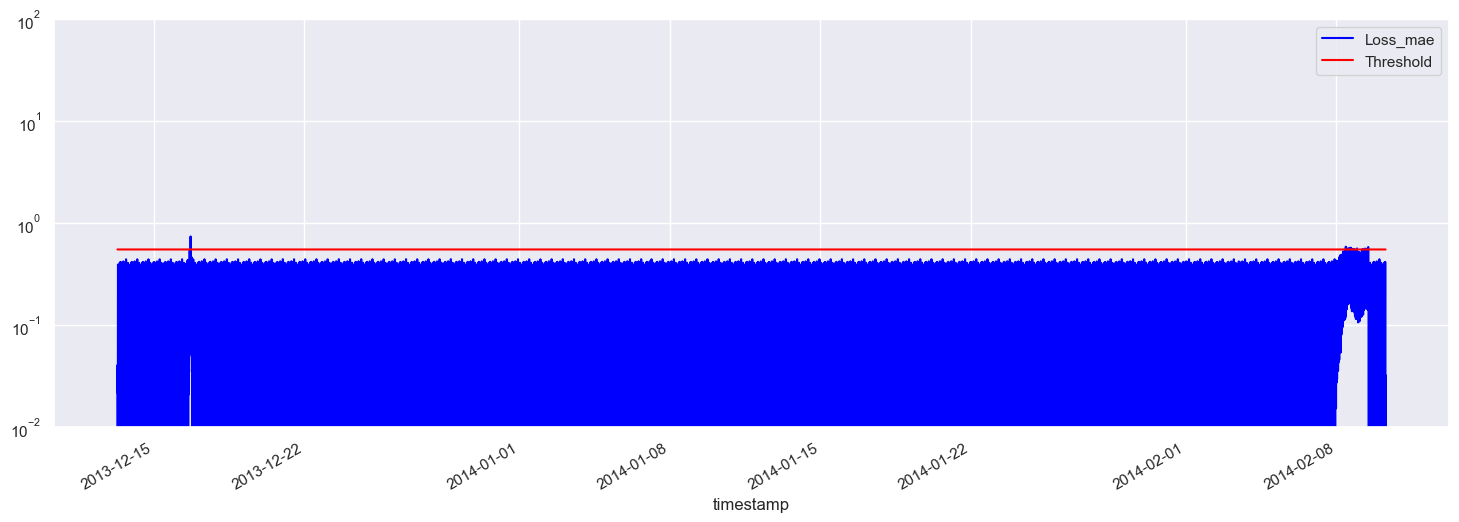

In [62]:
scored.plot(logy=True,  figsize=(18,6), ylim=[1e-2,1e2], color=['blue',
 'red'])

Plot the test data set to correlate with the anomaly points

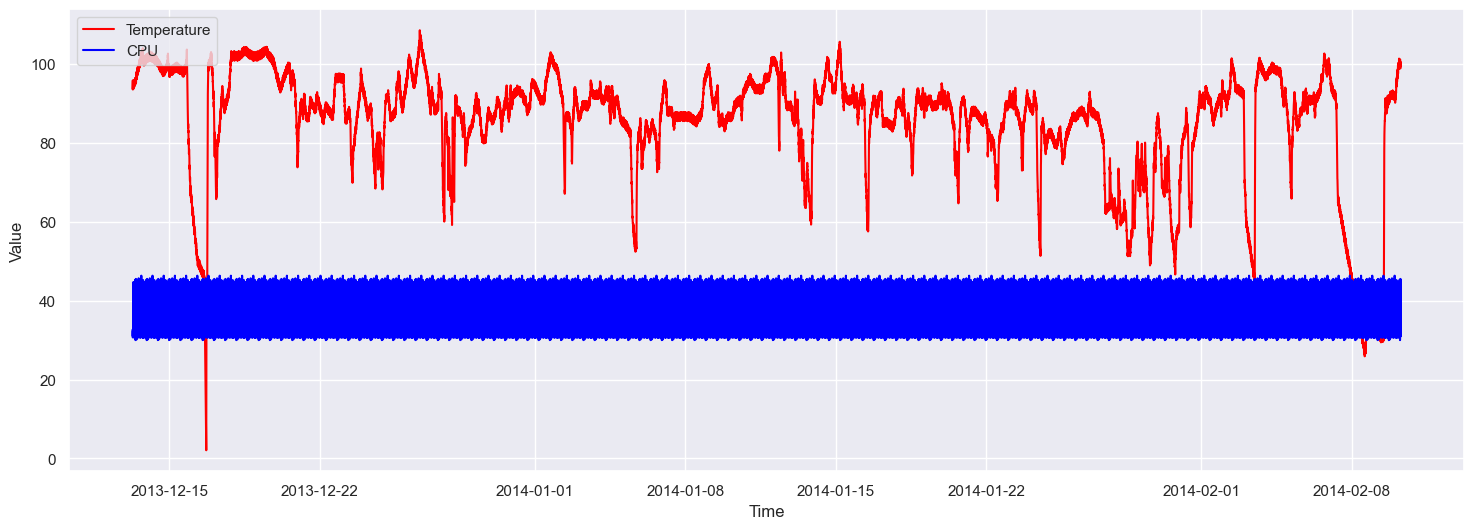

In [60]:
plot_features(test)